In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.signal as sg
from matplotlib.lines import Line2D
import gc
import os

sns.set(style='ticks', palette='Set2')
sns.despine()

<Figure size 432x288 with 0 Axes>

In [2]:
def filtering(field, dt, cutoff_freq_l, cutoff_freq_h, cushion=5000):
    HH = np.ma.size(field, axis=0)
    NN_og = np.ma.size(field, axis=1)
    NN = NN_og + cushion

    temp = np.zeros((HH, NN))
    field_initial = field[:,0]
    initial = np.tile(field_initial, (cushion, 1)).transpose()
    temp[:, :cushion] = initial
    temp[:, cushion:] = field
    gc.collect()

    nyq_freq = 0.5 / dt # in Hz
    normal_cutoff_l = cutoff_freq_l / nyq_freq
    b, a = sg.butter(4, normal_cutoff_l, btype='low', analog=False)
    filt_l = sg.lfilter(b, a, temp)
    gc.collect()
    
    normal_cutoff_h = cutoff_freq_h / nyq_freq
    b1, a1 = sg.butter(4, normal_cutoff_h, btype='high', analog=False)
    filt = sg.lfilter(b1, a1, filt_l)[:,cushion:]
    
    return filt

In [3]:
data = np.loadtxt('/Users/kcoppess/muspelheim/fdsnws-dataselect_2023-11-19t23_22_44z.csv', skiprows=19, usecols=1) / 1.6116e8

In [4]:
data_times = np.loadtxt('/Users/kcoppess/muspelheim/fdsnws-dataselect_2023-11-19t23_22_44z.csv', skiprows=19, usecols=0, dtype='str')

In [30]:
time_label = np.zeros(len(data_times))

for tt in range(len(data_times)):
    label = data_times[tt]
    hours = float(label[11:13])
    minutes = float(label[14:16])
    seconds = float(label[17:-2])
    time_label[tt] = (hours * 60 * 60) + (minutes * 60) + seconds
time_label[-1] += 24 * 60 * 60

In [28]:
time = np.arange(len(data)) * 0.01

In [33]:
filtered = filtering(np.array([data]), 0.01, 5, 0.8)[0]

In [34]:
envelope = np.abs(sg.hilbert(filtered))

In [35]:
NN = int(5 * 60 / 0.01)
hann_window = np.hanning(NN)

In [36]:
smoothing = []
tpts = []
for ii in range(len(data) - NN):
    tpts.append(time[ii + int(NN/2)])
    point = np.average(envelope[ii:(ii + NN)] * hann_window)
    smoothing.append(point)

smoothed = np.array(smoothing)
window_time = np.array(tpts)

In [37]:
t1start = np.argwhere(time >= (5 * 60 * 60))[0,0]
t1end = np.argwhere(time >= (16 * 60 * 60 + 45 * 60))[0, 0]

t2start = np.argwhere(time > (16 * 60 * 60 + 45 * 60))[0, 0]
t2end = np.argwhere(time > (20 * 60 * 60))[0, 0]

In [38]:
dt = 0.01

t1_tt = len(time[t1start:t1end])
t1_freq = np.fft.fftfreq(t1_tt, dt)

t1_freq08 = np.argwhere(t1_freq > 0.3)[0, 0]
t1_freq50 = np.argwhere(t1_freq > 5.5)[0, 0]

t1_N = len(t1_freq)*2 # number of Fourier sample points
t1_L = t1_N*dt # profile length

t1_ver_FFT = np.fft.fft(data[t1start:t1end]) * dt

t1_vertical_PSD = np.abs(t1_ver_FFT)**2 / t1_L

t1_vertical_PSD_dB = 10 * np.log10(t1_vertical_PSD)

In [39]:
dt = 0.01

t2_tt = len(time[t2start:t2end])
t2_freq = np.fft.fftfreq(t2_tt, dt)

t2_freq08 = np.argwhere(t2_freq > 0.3)[0, 0]
t2_freq50 = np.argwhere(t2_freq > 5.5)[0, 0]

t2_N = len(t2_freq)*2 # number of Fourier sample points
t2_L = t2_N*dt # profile length

t2_ver_FFT = np.fft.fft(data[t2start:t2end]) * dt

t2_vertical_PSD = np.abs(t2_ver_FFT)**2 / t2_L

t2_vertical_PSD_dB = 10 * np.log10(t2_vertical_PSD)

In [40]:
t1_median_window_size = np.argwhere(t1_freq >= 0.33)[0, 0]
t2_median_window_size = np.argwhere(t2_freq >= 0.33)[0, 0]

t1_median_PSD = sg.medfilt(t1_vertical_PSD[t1_freq08:t1_freq50], kernel_size = t1_median_window_size)
t2_median_PSD = sg.medfilt(t2_vertical_PSD[t2_freq08:t2_freq50], kernel_size = t2_median_window_size)

In [54]:
np.array([t1_freq[t1_freq08:t1_freq50], t1_median_PSD]).transpose().shape

(219960, 2)

In [57]:
np.savetxt('/Users/kcoppess/muspelheim/gestrich-model/pavlofData_t1_median_PSD.txt', np.array([t1_freq[t1_freq08:t1_freq50], t1_median_PSD]).transpose(), header='frequency  PSD')
np.savetxt('/Users/kcoppess/muspelheim/gestrich-model/pavlofData_t2_median_PSD.txt', np.array([t2_freq[t2_freq08:t2_freq50], t2_median_PSD]).transpose(), header='frequency  PSD')

<IPython.core.display.Javascript object>


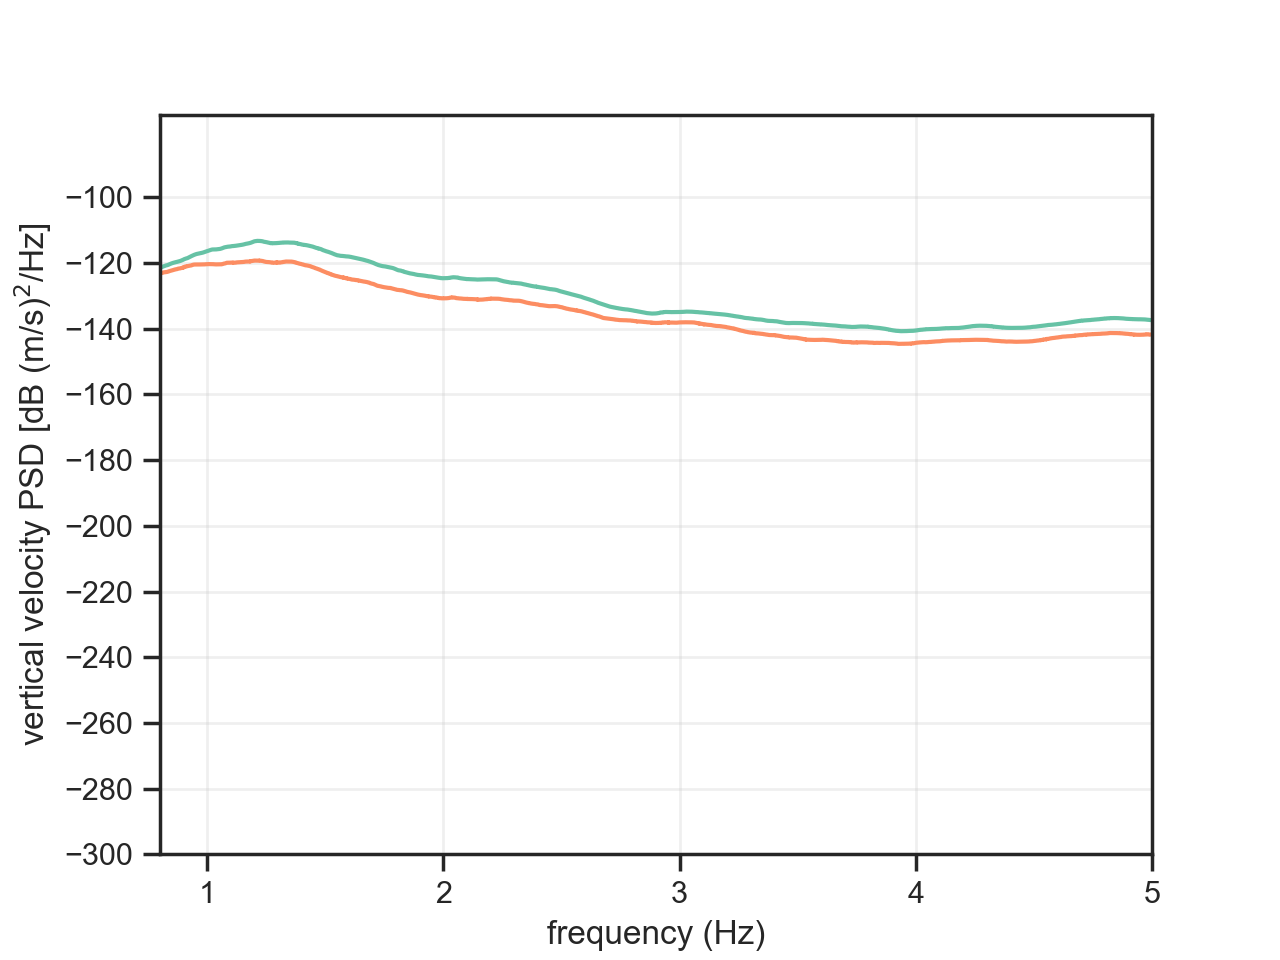

In [41]:
%matplotlib notebook

# plt.plot(t1_freq[:int(t1_tt/2)], t1_vertical_PSD_dB[:int(t1_tt/2)])
plt.plot(t1_freq[t1_freq08:t1_freq50], 10*np.log10(t1_median_PSD))
plt.plot(t2_freq[t2_freq08:t2_freq50], 10*np.log10(t2_median_PSD))

plt.grid(alpha=0.3)
plt.xlabel('frequency (Hz)')
plt.ylabel('vertical velocity PSD [dB (m/s)$^2$/Hz]')
plt.yticks(np.arange(-300, -85, 20.0))
plt.xticks(np.arange(0, 6, 1.0))
plt.xlim(0.8, 5)
plt.ylim(-300, -75)
plt.show()

<IPython.core.display.Javascript object>


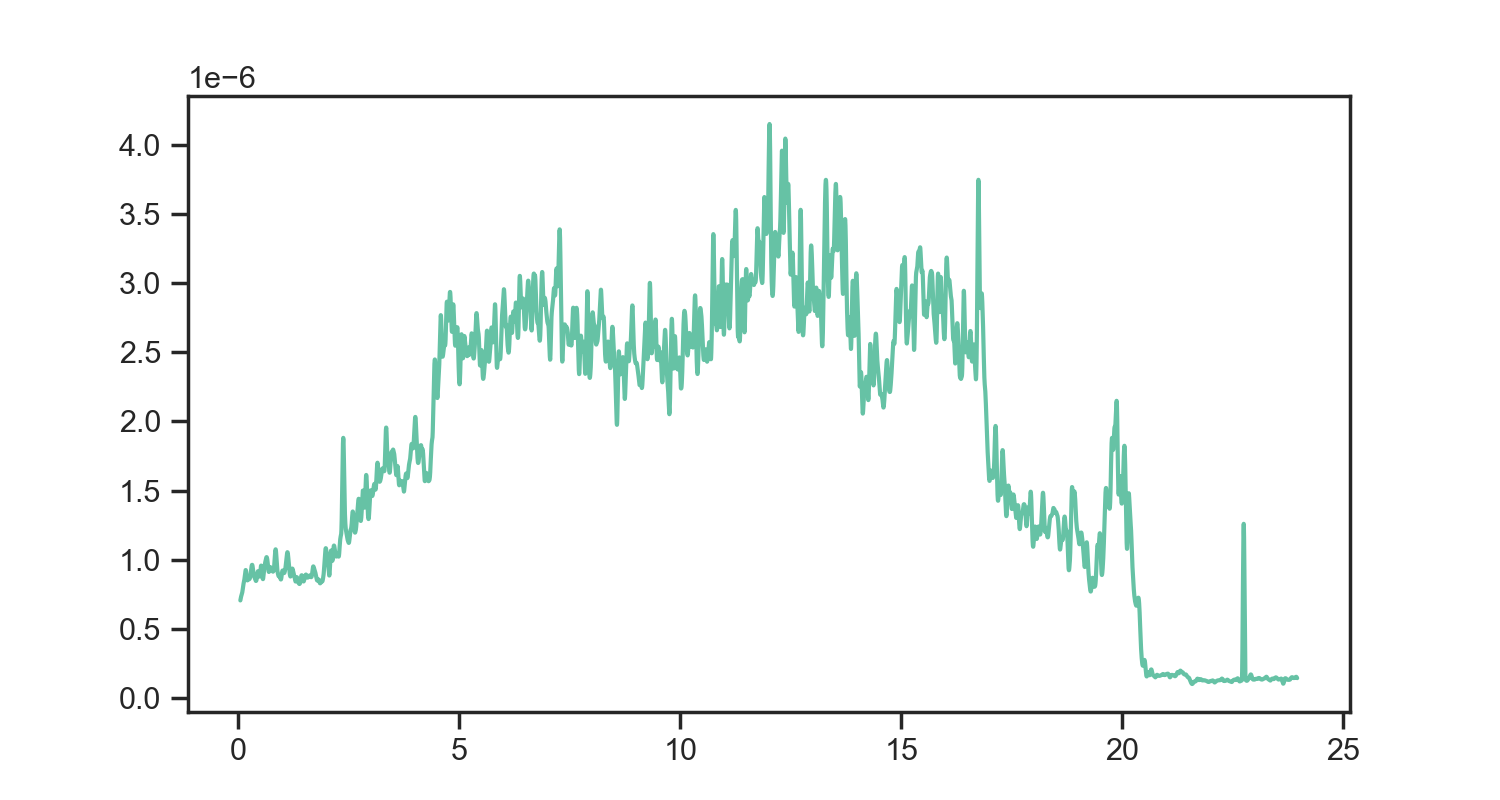

In [44]:
%matplotlib notebook

plt.figure(figsize=(7.5,4))

# plt.plot(time/60/60, filtered)
plt.plot(window_time/60/60, smoothed)
plt.show()